Logs:
- [2023/11/18].   
  This notebook is copied from from [Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series).  
  I also add some plots in the class WindowGenerator construction.

# Time series forecasting

This tutorial is an introduction to time series forecasting using TensorFlow.  
It builds a few different styles of models inclluding Convolutional and   
Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections:
- Forecast for a single time step:
  - A single feature.
  - All features.
- Foreacst multiple steps
  - Single-shot: Make the predictions all at once.
  - Autoregressive: Make one prediction at a time and feed the output back to 
    the model.

## Setup

In [1]:
import os 
import datetime 

import IPython
import IPython.display
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf 


2023-11-18 20:23:36.945727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-18 20:23:44.015925: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

## The weather dataset

This tutorial uses a [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/) 
recorded by the [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/).

This dataset contains 14 different features such as air temperature, atmospheric pressure,  
and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency,   
you will use only the data collected between 2009 and 2016. This section of the dataset   
was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)

In [3]:
zip_path = tf.keras.utils.get_file(
  origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip", 
  fname="jena_climate_2009_2016.csv.zip",
  extract=True
)
csv_path, _ = os.path.splitext(zip_path)

This tutorial will just deal with **hourly predictions**, so start by sub-sampling   
the data from 10-minute intervals to one-hour intervals:

In [4]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop("Date Time"), format="%d.%m.%Y %H:%M:%S")

Let's take a glance at the data. Here are the first few rows:

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time:

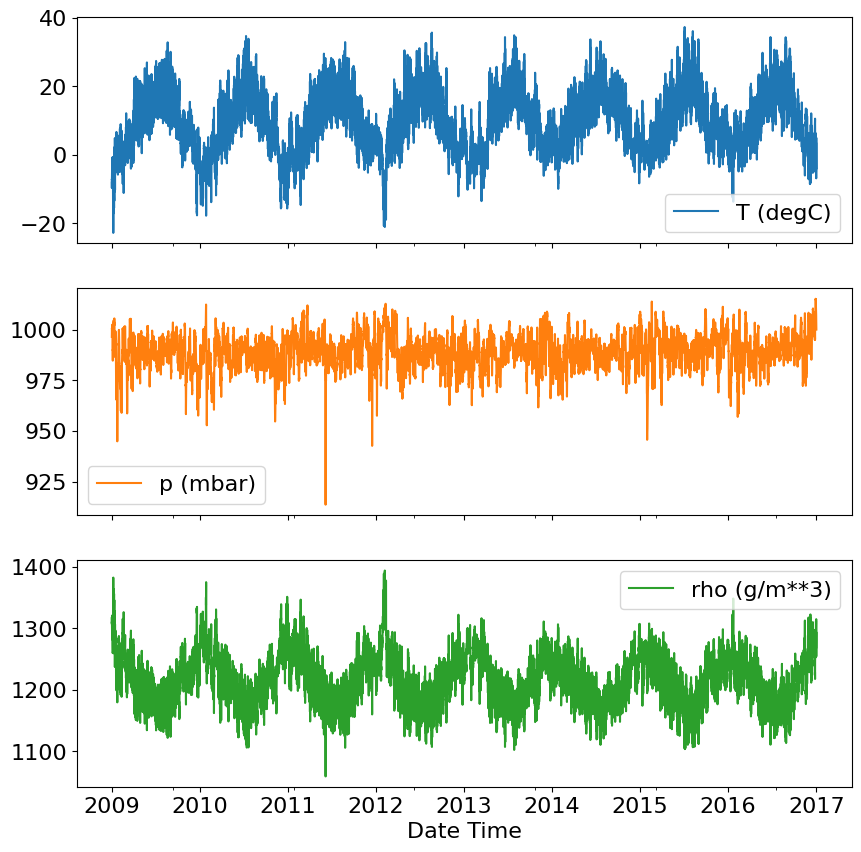

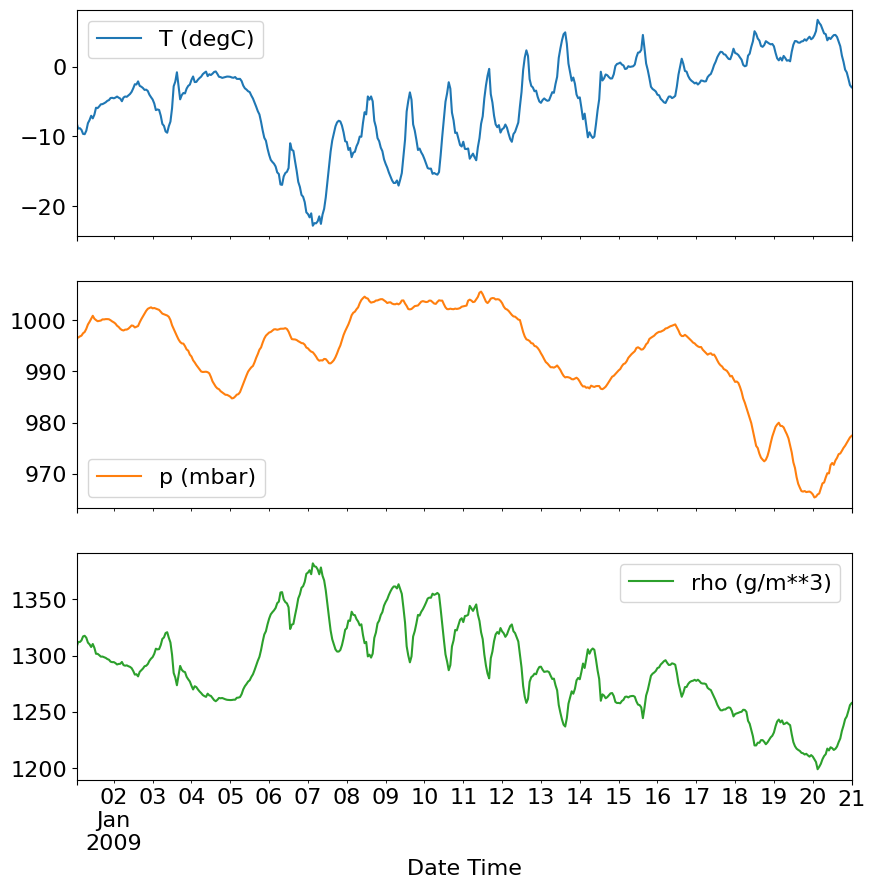

In [6]:
plot_cols = ["T (degC)", "p (mbar)", "rho (g/m**3)"]
plot_features = df[plot_cols]
plot_features.index = date_time

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
_ = plot_features.plot(subplots=True, ax=ax)
plt.show(fig)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True, ax=ax)
plt.show(fig)

### Inspect and cleanup

Next, look at the statistics of the dataset:

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


**Wind velocity**

One thing that should stand out is the `min` value of the wind velocity   
(`wv (m/s)`) and the maximum value (`max, wv (m/s)`) columns. This `-9999`  
is likely erroneous.

There's a separate wind direction column, so the velocity should be greater than  
zero (`>=0`). Replace it with zeros:

In [8]:
# we copy the DataFrame df, to avoid auto update to df and make each cell
# to be independent of each others.
df_clean = df.copy()
wv = df_clean["wv (m/s)"]
bad_wv = abs(wv - (-9999.0)) < 1e-6
wv[bad_wv] = 0.0

max_wv = df_clean["max. wv (m/s)"]
bad_max_wv = abs(max_wv - (-9999.0)) < 1e-6
max_wv[bad_max_wv] = 0.0

df_clean["wv (m/s)"].min()

0.0

### Feature engineering

Before diving in to build a model, it's important to understand your data and be   
sure that you're passing the model appropriately formatted data.

**Wind**  

The last column of the data, `wd (deg)`&ndash;gives the wind direction in units of   
degrees. Angles do not make good model input: 360&deg; and 0&deg; should be   
close to each other and wrap around smoothly. Direction shouldn't matter if the wind  
is not blowing.

Right now the distribution of wind data looks like this:

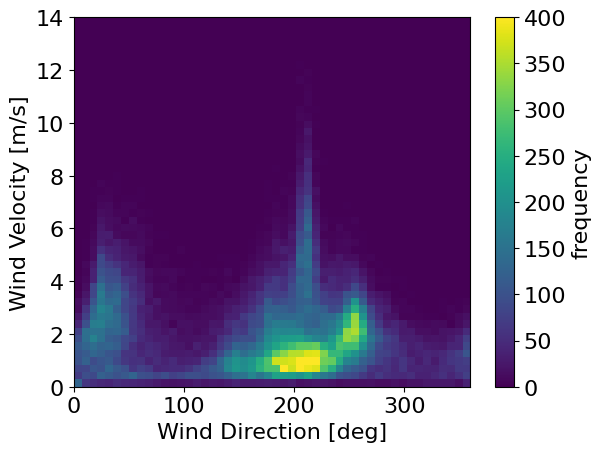

In [58]:
fig, ax = plt.subplots()

hist2d = ax.hist2d(df_clean["wd (deg)"], df_clean["wv (m/s)"], bins=(50, 50), vmax=400)

cbar = fig.colorbar(hist2d[3], ax=ax)   # the four elements of hist2d is QuadMesh
ax.set_xlabel("Wind Direction [deg]")
ax.set_ylabel("Wind Velocity [m/s]")

cbar.ax.set_ylabel("frequency")


plt.show(fig)

But this will be easier for the model to interpret if you convert the wind direction  
and velocity columns to a wind **vector**:

In [59]:
df_clean_wv_vec = df_clean.copy()

wv = df_clean_wv_vec.pop("wv (m/s)")
max_wv = df_clean_wv_vec.pop("max. wv (m/s)")

# Convert to radians
wd_rad = df_clean_wv_vec.pop("wd (deg)") * np.pi / 180

# Calculate the wind x and y components
df_clean_wv_vec["Wx"] = wv*np.cos(wd_rad)
df_clean_wv_vec["Wy"] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components
df_clean_wv_vec["max Wx"] = max_wv*np.cos(wd_rad)
df_clean_wv_vec["max Wy"] = max_wv*np.sin(wd_rad)

df_clean_wv_vec

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy
5,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503
11,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645
17,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576
23,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090
29,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,-0.855154,-0.160038,-1.336792,-0.250174
420527,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,-0.716196,-0.726267,-1.348134,-1.367090
420533,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,-0.661501,0.257908,-1.453438,0.566672
420539,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,-0.280621,-0.209169,-0.545207,-0.406385


The distribution of wind vectors is much simpler for the model to correctly interpret:

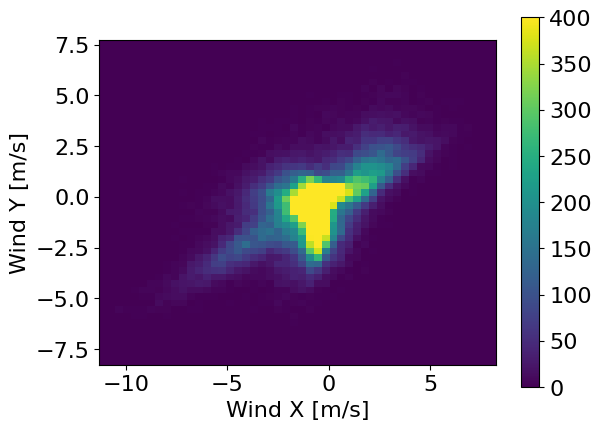

In [60]:
fig, ax = plt.subplots()

hist2d = ax.hist2d(df_clean_wv_vec["Wx"], df_clean_wv_vec["Wy"], bins=(50, 50), vmax=400)

fig.colorbar(hist2d[3], ax=ax)   # the four elements of hist2d is QuadMesh
ax.set_xlabel("Wind X [m/s]")
ax.set_ylabel("Wind Y [m/s]")
ax.set_aspect("equal")


plt.show(fig)


**Time**   

Similarly, the `Date Time` column is very useful, but not in this string form.  
Start by converting it to seconds:


In [12]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s

5         1.230772e+09
11        1.230775e+09
17        1.230779e+09
23        1.230782e+09
29        1.230786e+09
              ...     
420521    1.483211e+09
420527    1.483215e+09
420533    1.483219e+09
420539    1.483222e+09
420545    1.483226e+09
Name: Date Time, Length: 70091, dtype: float64

Similarly to the wind direction, the time in seconds is not a useful model input.  
Being weather data, it has clear daily and yearly periodicity. There are many ways  
you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear   
"Time of day" and "Time of year" signals:

In [62]:
day = 24*60*60        # day in seconds
year = 365.2425*day   # year in seconds

df_clean_wv_vec["Day sin"] = np.sin(timestamp_s * 2*np.pi/day)
df_clean_wv_vec["Day cos"] = np.cos(timestamp_s * 2*np.pi/day)
df_clean_wv_vec["Year sin"] = np.sin(timestamp_s * 2*np.pi/year)
df_clean_wv_vec["Year cos"] = np.cos(timestamp_s * 2*np.pi/year)

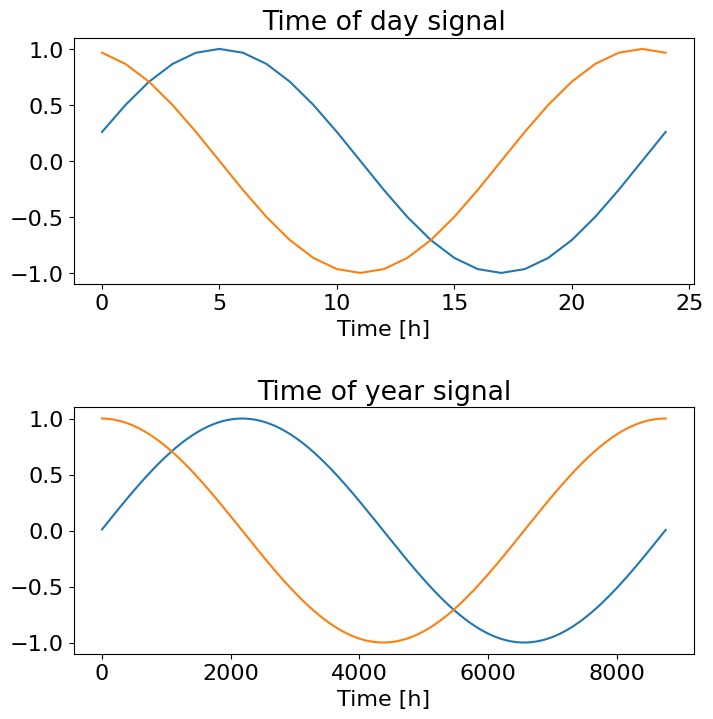

In [70]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

axes[0].plot(df_clean_wv_vec["Day sin"].to_numpy()[:25])
axes[0].plot(df_clean_wv_vec["Day cos"].to_numpy()[:25])

axes[0].set_xlabel("Time [h]")
axes[0].set_title("Time of day signal")


axes[1].plot(df_clean_wv_vec["Year sin"].to_numpy()[:365*24])
axes[1].plot(df_clean_wv_vec["Year cos"].to_numpy()[:365*24])

axes[1].set_xlabel("Time [h]")
axes[1].set_title("Time of year signal")

plt.subplots_adjust(hspace=0.5)
plt.show(fig)

This gives the model access to the most important frequency features. In this  
case you knew ahead of time which frequencies were important.   

If you don't have that information, you can determine which frequencies are   
important by extracting features with [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform).  
To check the assumptions, here is the `tf.signal.rfft` of the temperarture   
over time. Note the obvious peaks at frequencies near `1/year` and `1/day`

2023-11-18 20:24:02.706482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 20:24:02.924986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-18 20:24:02.925249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

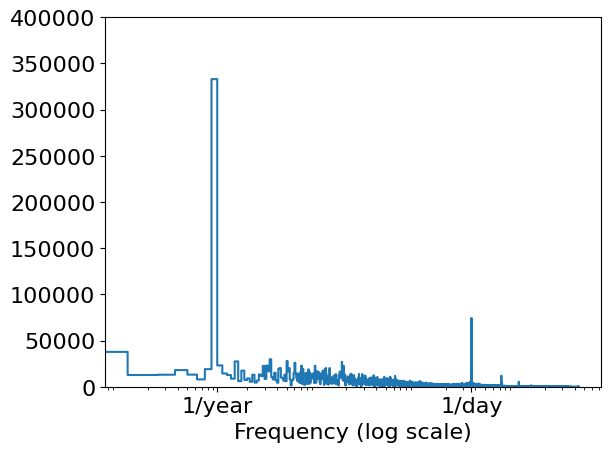

In [15]:
fft = tf.signal.rfft(df_clean_wv_vec["T (degC)"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_clean_wv_vec["T (degC)"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/hours_per_year

f_per_year = f_per_dataset/years_per_dataset

fig, ax = plt.subplots()

ax.step(f_per_year, np.abs(fft))
ax.set_xscale("log")
ax.set_ylim(0, 400_000)
ax.set_xticks([1, 365.2524], labels=["1/year", "1/day"])
ax.set_xlabel("Frequency (log scale)")

plt.show(fig)

### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets.   
Note the data is **not** being randomly shuffled before splitting. This is for   
two reasons:
1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated  
   on the data collected after the model was trained.

In [16]:
column_indices = {name: i for i, name in enumerate(df_clean_wv_vec.columns)}

n = len(df_clean_wv_vec)
train_val_split_idx = int(n*0.7)
val_test_split_idx = int(n*0.9)
train_df = df_clean_wv_vec[:train_val_split_idx]
val_df = df_clean_wv_vec[train_val_split_idx:val_test_split_idx]
test_df = df_clean_wv_vec[val_test_split_idx:]

num_features = df_clean_wv_vec.shape[1]
num_features

19

### Normalize the data

It is important to scale features before training a neural network.   
Normalization is a common way of doing this scaling: subtract the mean and divide  
by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data  
so that the models have no access to the values in the validation and test sets.  

It's also arguable that the model shouldn't have access to future values in   
the training, and that this normalization should be done using moving averages.  
That's not the focus this tutorial, and the validation and test sets ensures that  
you get (somewhat) honest metric. So, in the interest of simplicity this tutorial  
uses a simple average.

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df_normalized = (train_df - train_mean) / train_std
val_df_normalized = (val_df - train_mean) / train_std
test_df_normalized = (test_df - train_mean) / train_std

Now, peek at the distribution of the features. Some features do have long tails,  
but there are no obvious errors like the `-9999` wind velocity value.

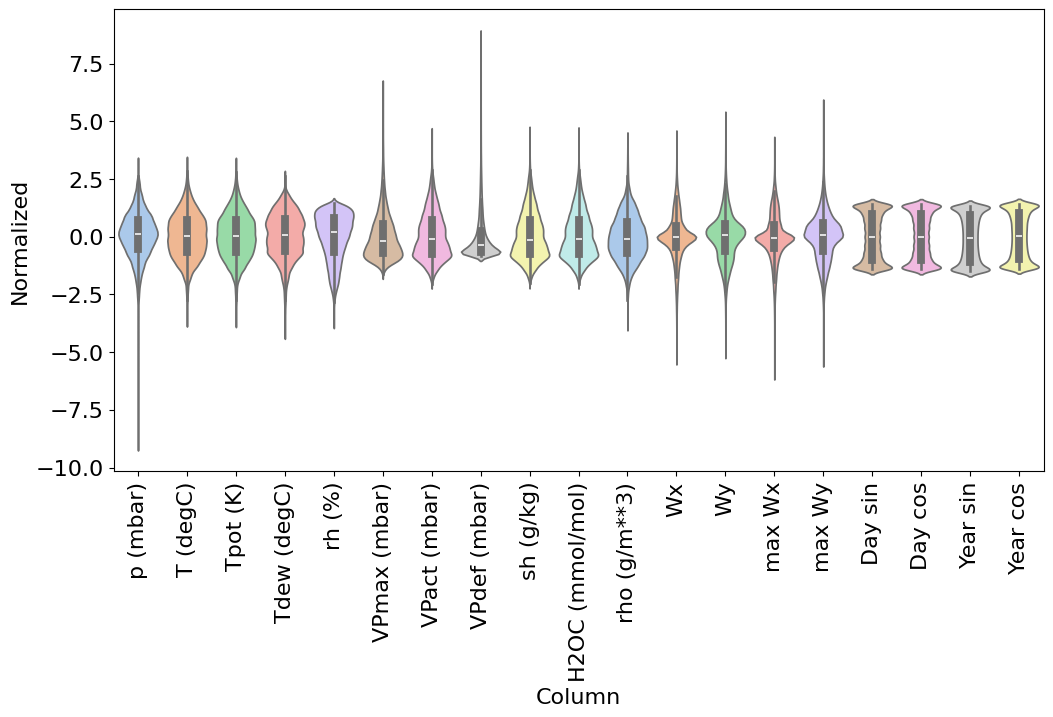

In [18]:
df_std = (df_clean_wv_vec - train_mean) / train_std

df_std = df_std.melt(var_name="Column", value_name="Normalized")
fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(x="Column", hue="Column", y="Normalized", data=df_std, ax=ax, palette="pastel", legend=False)

ax.set_xticks(np.arange(len(df_clean_wv_vec.columns)))
ax.set_xticklabels(df_clean_wv_vec.keys(), rotation=90)
plt.show(fig)


# Using matplotlib takes forever
# fig, ax = plt.subplots()
# ax.violinplot(df_std.values.T) 

## Data windowing

The models in this tutorial will make a set of predictions based on a window of   
consecutive samples from the data.  

The main features of the input windows are:
- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both.

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models),   
and uses them for both:
- _Single-output_, and _multi-output_ predictions.
- _Single-time-step_ and _multi-time-step_ predictions.

This section focuses on implementing the data windowing so that it can be reused   
for all of those models.

Depending on the task and type of model you may want to generate a variety of data  
windows. Here are some examples:
1. For example, to make a single prediction 24 hours into the future, given   
   24 hours of history, you might define a window like this: <br>
   ![raw_window_24h.png](./raw_window_24h.png)

2. A model that makes a prediction one hour into the future, given six hours of   
   history, would need a window like this: <br>
   ![raw_window_1h.png](./raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:
1. Handle the indexes and offsets as shown in the diagram above.
2. Split windows of features into `(features, labels)` pairs.  
3. Plot the content of the resulting windows.
4. Efficiently generate batches of these windows from the training, evaluation,   
   and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGeneraator` class. The `__init__` method includes   
all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will  
be converted to `tf.data.Dataset`s of window later.

In [83]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, 
                train_df=train_df, val_df=val_df, test_df=test_df, 
                label_columns=None):
    # Store the raw data.
    self.train_df = train_df 
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.  
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in 
                                    enumerate(label_columns)}

    self.column_indices = {name: i for i, name in 
                            enumerate(train_df.columns)}
    
    # Work out the window parameters.
    self.input_width = input_width 
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.label_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.label_slice]

  def __repr__(self):
    return "\n".join([
      f"Total window size: {self.total_window_size}", 
      f"Input indices: {self.input_indices}",
      f"Label indices: {self.label_indices}",
      f"Label column name(s): {self.label_columns}" 
    ])

Here is core to create the 2 windows shown in the diagrams at the start of this   
section:

In [84]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, 
                      label_columns=["T (degC)"])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [85]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, 
                      label_columns=["T (degC)"])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [86]:
w3 = WindowGenerator(input_width=24, label_width=3, shift=24, 
                      label_columns=["T (degC)"])
w3

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [45 46 47]
Label column name(s): ['T (degC)']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them   
to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:<br>
![split_window.png](./split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window`   
function also handles the `label_columns` so it can be used for both the single  
output and multi-output examples.

In [87]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.label_slice, :]

  if self.label_columns is not None:
    labels = tf.stack(
      [labels[:, :, self.column_indices[name]] for name in self.label_columns], 
      axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels


WindowGenerator.split_window = split_window

Try it out:

In [88]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, 
                      label_columns=["T (degC)"])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [89]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                            np.array(train_df[100:100+w2.total_window_size]), 
                            np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {example_window.shape}")
print(f"Inputs shape: {example_inputs.shape}")
print(f"Labels shape: {example_labels.shape}")

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index    
is across examples (the "batch" dimension). The middle indices are the "time" or "space"  
(width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at   
each time step. It splits them into a batch of 6-time step 19-feature inputs, and  
a 1-time step 1-feature label. The label only has one feature because the   
`WindowGenerator` was initialized with `label_column=["T (degC)"]`. Initially, this   
tutorial will build models that predict single output labels.

Let's test to `w1`

In [90]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, 
                      label_columns=["T (degC)"])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [91]:
# Stack three slices, the length of the total window.
w1_example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                            np.array(train_df[100:100+w1.total_window_size]), 
                            np.array(train_df[200:200+w1.total_window_size])])

w1_example_inputs, w1_example_labels = w1.split_window(w1_example_window)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {w1_example_window.shape}")
print(f"Inputs shape: {w1_example_inputs.shape}")
print(f"Labels shape: {w1_example_labels.shape}")


All shapes are: (batch, time, features)
Window shape: (3, 48, 19)
Inputs shape: (3, 24, 19)
Labels shape: (3, 1, 1)


Test also to another window, `w3`

In [92]:
# Stack three slices, the length of the total window.
w3_example_window = tf.stack([np.array(train_df[:w3.total_window_size]),
                            np.array(train_df[100:100+w3.total_window_size]), 
                            np.array(train_df[200:200+w3.total_window_size])])

w3_example_inputs, w3_example_labels = w3.split_window(w3_example_window)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {w3_example_window.shape}")
print(f"Inputs shape: {w3_example_inputs.shape}")
print(f"Labels shape: {w3_example_labels.shape}")

All shapes are: (batch, time, features)
Window shape: (3, 48, 19)
Inputs shape: (3, 24, 19)
Labels shape: (3, 3, 1)


### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [93]:
w2.example = example_inputs, example_labels

In [94]:
def plot(self, model=None, plot_col="T (degC)", max_subplots=3):
  inputs, labels = self.example
  max_n = min(max_subplots, len(inputs))

  fig, axes = plt.subplots(nrows=max_n, ncols=1, figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]

  for n in range(max_n):
    axes[n].plot(self.input_indices, inputs[n, :, plot_col_index],
                  label="Inputs", marker=".", zorder=-10)
    axes[n].set_ylabel(f"{plot_col}\n[normed]") 
  
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    axes[n].scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c="#2ca02c", s=64) 
    if model is not None:
      predictions = model(inputs)
      axes[n].scatter(self.label_indices, predictions[n, :, label_col_index], 
                  marker="X", edgecolors="k", label="Predictions",
                  c="#ff7f0e", s=64)
  
    if n == 0:
      axes[n].legend()

  
  axes[-1].set_xlabel("Time [h]")

  plt.show(fig)


WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that  
the item refers to:

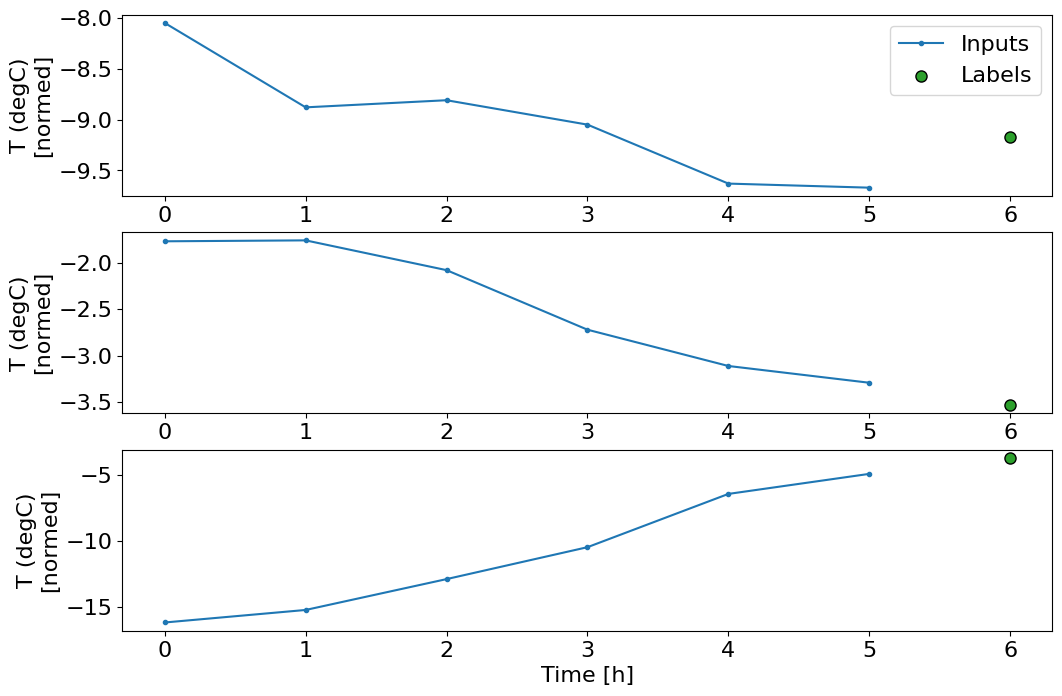

In [95]:
w2.plot()

You can plot the other columns, but the example `w2` configuration only has labels  
for the `T (degC)` column.

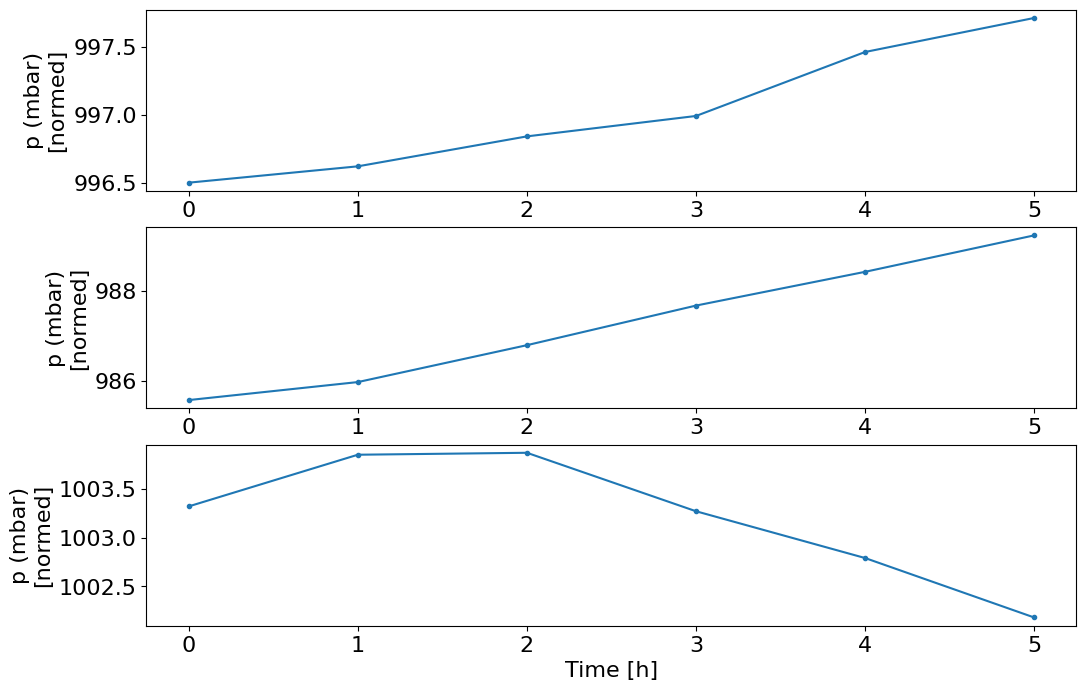

In [96]:
w2.plot(plot_col="p (mbar)")

Test for `w3`

In [97]:
w3.example = w3_example_inputs, w3_example_labels

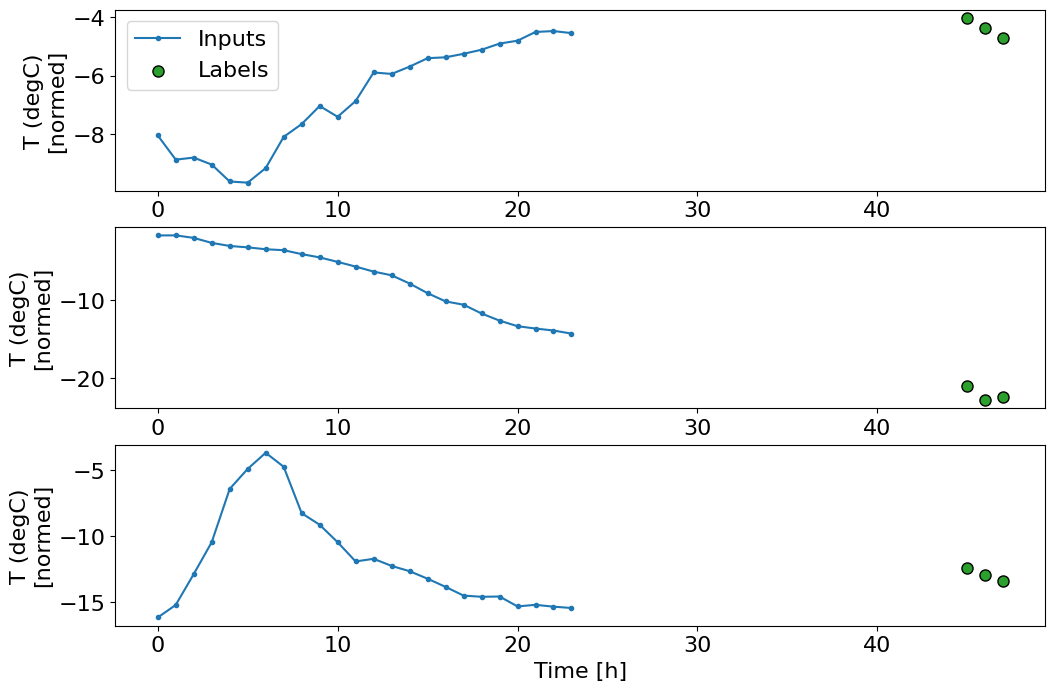

In [98]:
w3.plot()

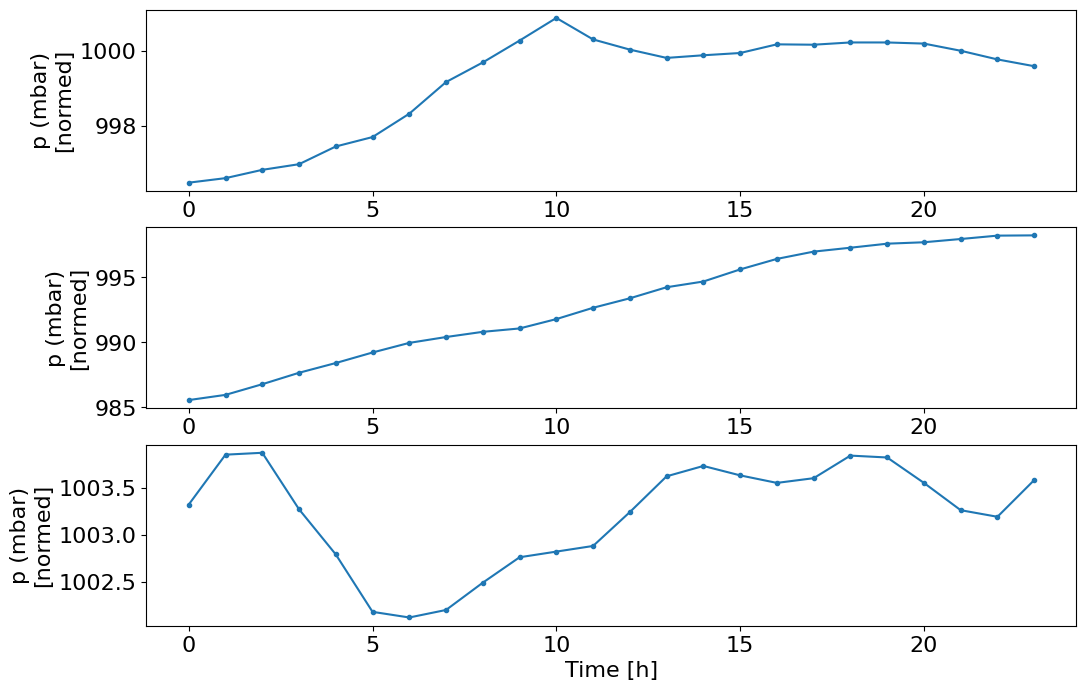

In [102]:
w3.plot(plot_col="p (mbar)")

### 4. Create `tf.data.Datasets`

Finally, this `make_dataset` method will take a time series DataFrame and convert   
it to a `tf.data.Dataset` of `(input_window, label_window)` pair using the   
`tf.keras.utils.timeseries_dataset_from_array` function:

In [46]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
    data=data, 
    targets=None, 
    sequence_length=self.total_window_size, 
    sequence_stride=1, 
    shuffle=True, 
    batch_size=32)
  
  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset`  
method you defined earlier. Also, add a standard example batch for easy access  
and plotting:

In [47]:
@property  
def train(self):
  return self.make_dataset(self.train_df)

@property 
def val(self):
  return self.make_dataset(self.val_df)

@property 
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache and example batch of `inptus, labels` for plotting."""  
  result = getattr(self, "_example", None)
  if result is None: 
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result

  return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset`   
objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and  
shapes of the dataset elements.

In [48]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [49]:
for example_inputs, example_labels in w2.train.take(1):
  print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
  print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single   
feature's value&mdash;1 time step (one hour) into the future based only on the   
current conditions.

So, start by building models to predict the `T (degC)` value one hour into the future.<br>
![narrow_window.png](./narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step 
`(input, label)` pairs:

In [50]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1,
                                      label_columns=["T (degC)"])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The `window` object creates `tf.data.Dataset`s from the training, validation, and   
test sets, allowing you to easily iterate over batches of data.

In [51]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
  print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline  
as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into future, given the current  
value of all features. The current values include the current temperature.

So, start with a model that just returns the current temperature as the prediction,  
predicting "No change". This is a reasonable baseline since temperature changes slowly.   
Of course, this baseline will work less well if you make a prediction further in   
the future.<br>
![baseline.png](./baseline.png)

In [52]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [53]:
baseline = Baseline(label_index=column_indices["T (degC)"])
baseline.compile(loss=tf.keras.losses.MeanSquaredError(), 
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(single_step_window.val)
performance["Baseline"] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 2ms/step - loss: 0.9622 - mean_absolute_error: 0.6791


That printed some performance metrics, but those don't give you a feeling for  
how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting   
with only a single sample.

So, create a wider `WindowGenerator` that generates windows 24 hours of consecutives  
inputs and labels at a time. The new `wide_window` variable doesn't change the way   
the model operates. The model still makes predictions one hour into the future  
based on a single input time step. Here, the `time` axis acts like the `batch`  
axis: each prediction is made independently with no interaction between time steps:

In [54]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, 
                              label_columns=["T (degC)"])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same `baseline` model without  
any code changes. This is possible because the inputs and labels have the same  
number of time steps, and the baseline just forwards the input to the output: <br>
![last_window.png](./last_window.png)

In [55]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


By plotting the baseline model's predictions, notice that it is simply the labels  
shifted right by one hour:

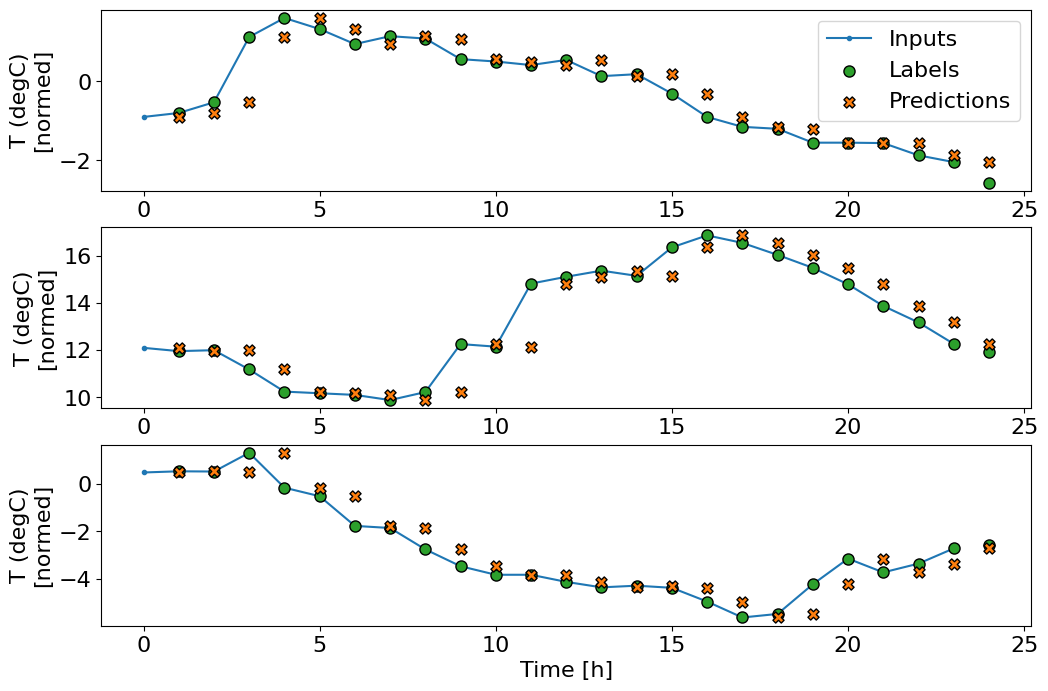

In [56]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course   
of 24 hours. This deserves some explanation:
- The blue `Inputs` line shows the input temperature at each time step. The model  
  receives all features, this plot only shows the temperature.
- The green `Labels` dots show the target prediction value. These dots are shown  
  at the prediction time, not the input time. That is why the range of labels is   
  shifted 1 step to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output   
  time step. If the model were predicting perfectly the predictions would land  
  direclty on the `Labels`